# Mortality modeling using neural networks

Linked files: 

FoM Exploratory Data Analysis: visualisation of the data

FoM Hyperparameter tuning: tuning of the parameters that will be used here

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.utils import shuffle
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, BatchNormalization, Dropout, Concatenate
from keras.utils import plot_model

C:\Users\liesv\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1. Importing the dataset

In [2]:
os.chdir("..")
MYwd= os.getcwd()
file_path = MYwd+"\Data\mortality.csv"

df = pd.read_csv(file_path)

# add a column with the mortality rates (originally, only the log_mortality rates are included)
df['mortality'] = np.exp(df['log_mortality'])

# the dataset contains data from west and east germany seperately. we only use the rates for the entire population of germany (DEUT)
df = df[(df['Country'].isin(["CHE","DEUT","DNK", "ESP", "FRATNP", "ITA", "JPN", "POL", "USA"]))]

print(df.head(10))
#print(df.info())


  Country  Year  Gender  Age  log_mortality  mortality
0     CHE  1950  Female    0      -3.601125   0.027293
1     CHE  1950  Female    1      -5.793926   0.003046
2     CHE  1950  Female    2      -6.392539   0.001674
3     CHE  1950  Female    3      -6.697494   0.001234
4     CHE  1950  Female    4      -6.900780   0.001007
5     CHE  1950  Female    5      -7.476916   0.000566
6     CHE  1950  Female    6      -7.374564   0.000627
7     CHE  1950  Female    7      -7.469874   0.000570
8     CHE  1950  Female    8      -7.492945   0.000557
9     CHE  1950  Female    9      -7.885921   0.000376


## 2. Data processing
The input needs to be made suitable for the neural network

In [3]:
# check the types of the different variables in the dataset 
print(df.dtypes)

Country           object
Year               int64
Gender            object
Age                int64
log_mortality    float64
mortality        float64
dtype: object


In [4]:
# Transfer to categorical variables
df['Country_cat'] = df['Country'].astype('category')
df['Gender_cat'] = df['Gender'].astype('category')

df['Country'] = df['Country_cat'].cat.codes
df['Gender'] = df['Gender_cat'].cat.codes

df['Year'] = df['Year'].astype('float')    
df['Age'] = df['Age'].astype('float')

print(df.dtypes)


Country              int8
Year              float64
Gender               int8
Age               float64
log_mortality     float64
mortality         float64
Country_cat      category
Gender_cat       category
dtype: object


In [5]:
# show the mappings of the countries to the categorical variables
country_mapping = df[['Country_cat', 'Country']].drop_duplicates().reset_index(drop=True)
print(country_mapping)

  Country_cat  Country
0         CHE        0
1        DEUT        1
2         DNK        2
3         ESP        3
4      FRATNP        4
5         ITA        5
6         JPN        6
7         POL        7
8         USA        8


In [6]:
# show the mappings of the genders to the categorical variables
gender_mapping = df[['Gender_cat', 'Gender']].drop_duplicates().reset_index(drop=True)
print(gender_mapping)

  Gender_cat  Gender
0     Female       0
1       Male       1


## 3. Prepare training and test set for the neural network
Training data: mortality rates from 1956 - 2005 

Test data: mortality rates from 2006 - 2016

In [7]:
# Set up the training set
train = df[(df['Year'].between(1956, 2005))].copy()
train = train.drop(columns=['Country_cat', 'Gender_cat']).reset_index(drop=True)

test_set = df[(df['Year'].between(2006, 2016))].copy()
test_set = test_set.drop(columns=['Country_cat', 'Gender_cat']).reset_index(drop=True)

## 4. Set up the neural network architecture
This is based on the model from listing 2 in the paper 'A neural network extension of the Lee-Carter model to multiple populations'


In [9]:
# Mean and std for normalization of input data
year_mean, year_std = train['Year'].mean(), train['Year'].std()
age_mean, age_std = train['Age'].mean(), train['Age'].std()


In [10]:
# function to normalize and prepare the data for training

def normalize_data(data, embed_age=True):
    year = data['Year'].values.reshape(-1,1)
    age = data['Age'].values.reshape(-1,1)
    gender = data['Gender'].values.reshape(-1,1)
    country = data['Country'].values.reshape(-1,1)
    
    year_norm = (year - year_mean) / year_std
    age_norm = (age - age_mean) / age_std
    
    if embed_age:
        X = [year_norm, age, gender, country]
    else:
        X = [year_norm, age_norm, gender, country]
    
    Y = data['log_mortality'].values.reshape(-1,1)
    
    return X, Y

In [11]:
# Build the neural network model

def build_model(embed_age=True):
    
    # Define the input layers
    year = Input(shape=(1,), dtype='float32', name='year')
    age = Input(shape=(1,), dtype='float32', name='age')
    gender = Input(shape=(1,), dtype='float32', name='gender')
    country = Input(shape=(1,), dtype='float32', name='country')
    
    # Define embedding layers for categorical variables
    age_embed = Embedding(input_dim=101, output_dim=20, name='age_embed')(age)
    age_embed = Flatten()(age_embed)

    gender_embed = Embedding(input_dim=2, output_dim=2, name='gender_embed')(gender)
    gender_embed = Flatten()(gender_embed)
    
    country_embed = Embedding(input_dim=9, output_dim=3, name='country_embed')(country)
    country_embed = Flatten()(country_embed)
    
    # Concatenate the defined features
    if embed_age:
        features = Concatenate()([year, age_embed, gender_embed, country_embed])
    else:
        features = Concatenate()([year, age, gender_embed, country_embed])
    
    # Define the hidden layers
    d1 = Dense(units=256, activation='relu')(features)
    d1 = BatchNormalization()(d1)
    d1 = Dropout(0.2)(d1)
    
    d2 = Dense(units=256, activation='relu')(d1)
    d2 = BatchNormalization()(d2)
    d2 = Dropout(0.2)(d2)

    # Define the output layer
    target = Dense(units=1, activation='linear')(d2)
    
    model = Model(inputs=[year, age, gender, country], outputs=target)

    adam_optimizer = tf.keras.optimizers.Adam(0.0005)
    model.compile(optimizer=adam_optimizer, loss='mse')
    
    return model

In [12]:
# Training the model
X_train, Y_train = normalize_data(train, embed_age=True)
X_test, Y_test = normalize_data(test_set, embed_age=True)

model = build_model()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=100, verbose=1, restore_best_weights=True)

history = model.fit(x=X_train, y=Y_train, batch_size=128, epochs=1000, verbose=1, callbacks=[earlystop])
        


Epoch 1/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 13.9593
Epoch 2/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0519
Epoch 3/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.7153
Epoch 4/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5144
Epoch 5/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3820
Epoch 6/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3153
Epoch 7/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2667
Epoch 8/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2290
Epoch 9/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2096
Epoch 10/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1894
Epoch 11/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1755
Epoch 12/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1590
Epoch 13/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1498
Epoch 14/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1374
Epoch 15/1000
707/707 ━━━━━━

707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0860
Epoch 158/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0927
Epoch 159/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0933
Epoch 160/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0896
Epoch 161/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0868
Epoch 162/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0801
Epoch 163/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0873
Epoch 164/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0903
Epoch 165/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0890
Epoch 166/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0877
Epoch 167/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0936
Epoch 168/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0933
Epoch 169/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0844
Epoch 170/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0817
Epoch 171/1000
707/70

707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0821
Epoch 314/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0772
Epoch 315/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0839
Epoch 316/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0780
Epoch 317/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0792
Epoch 318/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0748
Epoch 319/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0796
Epoch 320/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0743
Epoch 321/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0823
Epoch 322/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0805
Epoch 323/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0753
Epoch 324/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0853
Epoch 325/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0842
Epoch 326/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0763
Epoch 327/1000
707/70

707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0791
Epoch 470/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0726
Epoch 471/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0716
Epoch 472/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0784
Epoch 473/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0720
Epoch 474/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0771
Epoch 475/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0767
Epoch 476/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0749
Epoch 477/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0751
Epoch 478/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0791
Epoch 479/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0704
Epoch 480/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0792
Epoch 481/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0719
Epoch 482/1000
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0729
Epoch 483/1000
707/70

In [13]:
# save the model
#model.save("NNmodelForceOfMortality.keras")

# Load the model
#X_train, Y_train = normalize_data(train, embed_age=True)
#X_test, Y_test = normalize_data(test_set, embed_age=True)

#loaded_model = tf.keras.models.load_model("NNmodelForceOfMortality.keras")

### Test the model

In [14]:
# loss on training data: 
score_train = model.evaluate(X_train, Y_train, verbose=0)
print(f'score train:{score_train}')

score = model.evaluate(X_test, Y_test, verbose=0)

print(model.metrics_names)
print(f'score test: {score}')

score train:0.014125694520771503
['loss']
score test: 0.03786146640777588


## 5. Predict and project mortality with neural network


613/613 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
       Country    Year  Gender    Age  log_mortality  mortality  prediction  \
0            0  2006.0       0    0.0      -5.525218   0.003985   -5.615105   
1            0  2006.0       0    1.0      -7.995428   0.000337   -8.189780   
2            0  2006.0       0    2.0      -9.372859   0.000085   -8.808136   
3            0  2006.0       0    3.0      -8.866751   0.000141   -9.112994   
4            0  2006.0       0    4.0      -9.097012   0.000112   -9.107761   
...        ...     ...     ...    ...            ...        ...         ...   
19589        8  2016.0       1   96.0      -1.181204   0.306909   -1.093910   
19590        8  2016.0       1   97.0      -1.139750   0.319899   -0.956999   
19591        8  2016.0       1   98.0      -1.004789   0.366122   -0.882325   
19592        8  2016.0       1   99.0      -0.946588   0.388063   -0.721605   
19593        8  2016.0       1  100.0      -0.874974   0.416873   -0.646332   

       pre

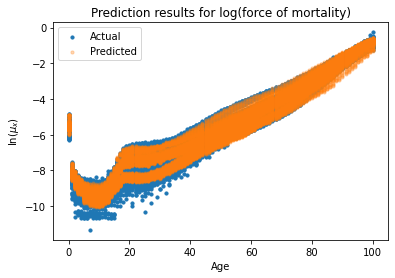

In [29]:
# predictions on the test set: 
predic = model.predict(X_test)

test_set['prediction'] = predic
print(test_set)

plt.scatter(test_set['Age'], test_set['log_mortality'], label="Actual", s=10)
plt.scatter(test_set['Age'], test_set['prediction'], label="Predicted", alpha=0.3, s=10)
plt.legend()
plt.title('Prediction results for log(force of mortality)')
plt.xlabel('Age')
plt.ylabel('$\ln(\mu_x)$')
plt.show()

In [17]:
# save results to excel to compare with LC;
#test_set.to_excel('predictions_NN_DAVdata.xlsx', index=False)

In [1]:
###############################################
###             Plot per country            ###
###############################################

countries = range(9)  # 9 countries
num_countries = 9

# Set up a 3x3 grid for subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the 3x3 array for easier iteration

# Define colormaps
cmap_blue = sns.color_palette("Blues", as_cmap=True)
#cmap_red = sns.color_palette("Reds", as_cmap=True)
cmap_red = sns.color_palette("Oranges", as_cmap=True)

# Normalize year range for consistent colors across plots
year_min, year_max = test_set['Year'].min(), test_set['Year'].max()
norm = plt.Normalize(year_min, year_max)

for ax, country in zip(axes, countries):
    country_data = test_set[test_set['Country'] == country]  # Filter data for country
    
    # Scatter plot for actual values (blue shades)
    ax.scatter(country_data['Age'], country_data['log_mortality'], 
               c=[cmap_blue(norm(y)) for y in country_data['Year']], 
               marker='o', alpha=0.9, s=20)

    # Scatter plot for predicted values (red shades)
    ax.scatter(country_data['Age'], country_data['prediction'], 
               c=[cmap_red(norm(y)) for y in country_data['Year']], 
               marker='o', alpha=0.3, s=20)
    
    ax.set_title(f'Country {country}')
    ax.set_xlabel('Age')
    ax.set_ylabel(r'$\ln(\mu_x)$')
    
    legend_markers = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap_blue(norm((year_max+year_min)/2)), markersize=10, label="Actual"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap_red(norm((year_max+year_min)/2)), markersize=10, label="Predicted")
    ]
    ax.legend(handles=legend_markers)
    #ax.legend()

cbar_ax_blue = fig.add_axes([0.92, 0.55, 0.02, 0.3])  # Position for actual values color bar
sm_blue = plt.cm.ScalarMappable(cmap=cmap_blue, norm=norm)
fig.colorbar(sm_blue, cax=cbar_ax_blue, label="Year (Actual, Blue)")

cbar_ax_red = fig.add_axes([0.92, 0.15, 0.02, 0.3])  # Position for predicted values color bar
sm_red = plt.cm.ScalarMappable(cmap=cmap_red, norm=norm)
fig.colorbar(sm_red, cax=cbar_ax_red, label="Year (Predicted, Red)")

NameError: name 'plt' is not defined

In [20]:
from sklearn.metrics import mean_squared_error

# Group by Country and Year, then calculate MSE for each group
mse_df = test_set.groupby(['Country', 'Year']).apply(
    lambda group: mean_squared_error(group['log_mortality'], group['prediction'])
).reset_index(name='MSE')


# We compare the worst, best and average performing country with outcomes of the Lee-Carter model
worst = mse_df[mse_df['MSE'] == max(mse_df['MSE'])]
best = mse_df[mse_df['MSE'] == min(mse_df['MSE'])]
average = mse_df[mse_df['MSE'] == (mse_df['MSE'].median())]

average

,Country,Year,MSE
95,8,2015.0,0.025132


In [21]:
mse_country = mse_df.groupby('Country')['MSE'].mean().reset_index(name='Average_MSE')

worst_country = mse_country[mse_country['Average_MSE'] == max(mse_country['Average_MSE'])]
average_country = mse_country[mse_country['Average_MSE'] == (mse_country['Average_MSE']).median()]
best_country = mse_country[mse_country['Average_MSE'] == min(mse_country['Average_MSE'])]

print(worst_country)
print(average_country)
print(best_country)

   Country  Average_MSE
2        2     0.094386
   Country  Average_MSE
7        7     0.020403
   Country  Average_MSE
8        8     0.014184


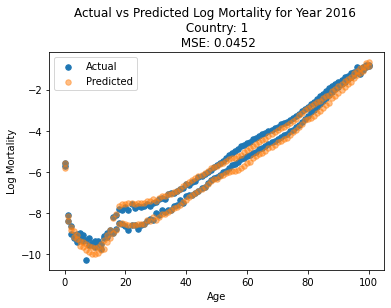

In [22]:
# Specify the year you want to visualize
year_to_plot = 2016 
country_to_plot = 1  # see mappings
#gender_to_plot = 0  

mse_row = mse_df[(mse_df['Country'] == country_to_plot) & (mse_df['Year'] == year_to_plot)]
mse = mse_row['MSE'].values[0]

# Filter test_set for the specified year, country, and gender,
test_subset = test_set[
        (test_set['Year'] == year_to_plot) & 
        (test_set['Country'] == country_to_plot)
        # & (test_set['Gender'] == gender_to_plot)
]

# Plot the actual and predicted log mortality for the chosen year\n",
plt.scatter(test_subset['Age'], test_subset['log_mortality'], label="Actual", s=30)
plt.scatter(test_subset['Age'], test_subset['prediction'], label="Predicted", s=30, alpha=0.5)
plt.legend()
plt.xlabel("Age")
plt.ylabel("Log Mortality")
plt.title(f"Actual vs Predicted Log Mortality for Year {year_to_plot} \n Country: {country_to_plot} \n MSE: {mse:.4f}")
plt.show()

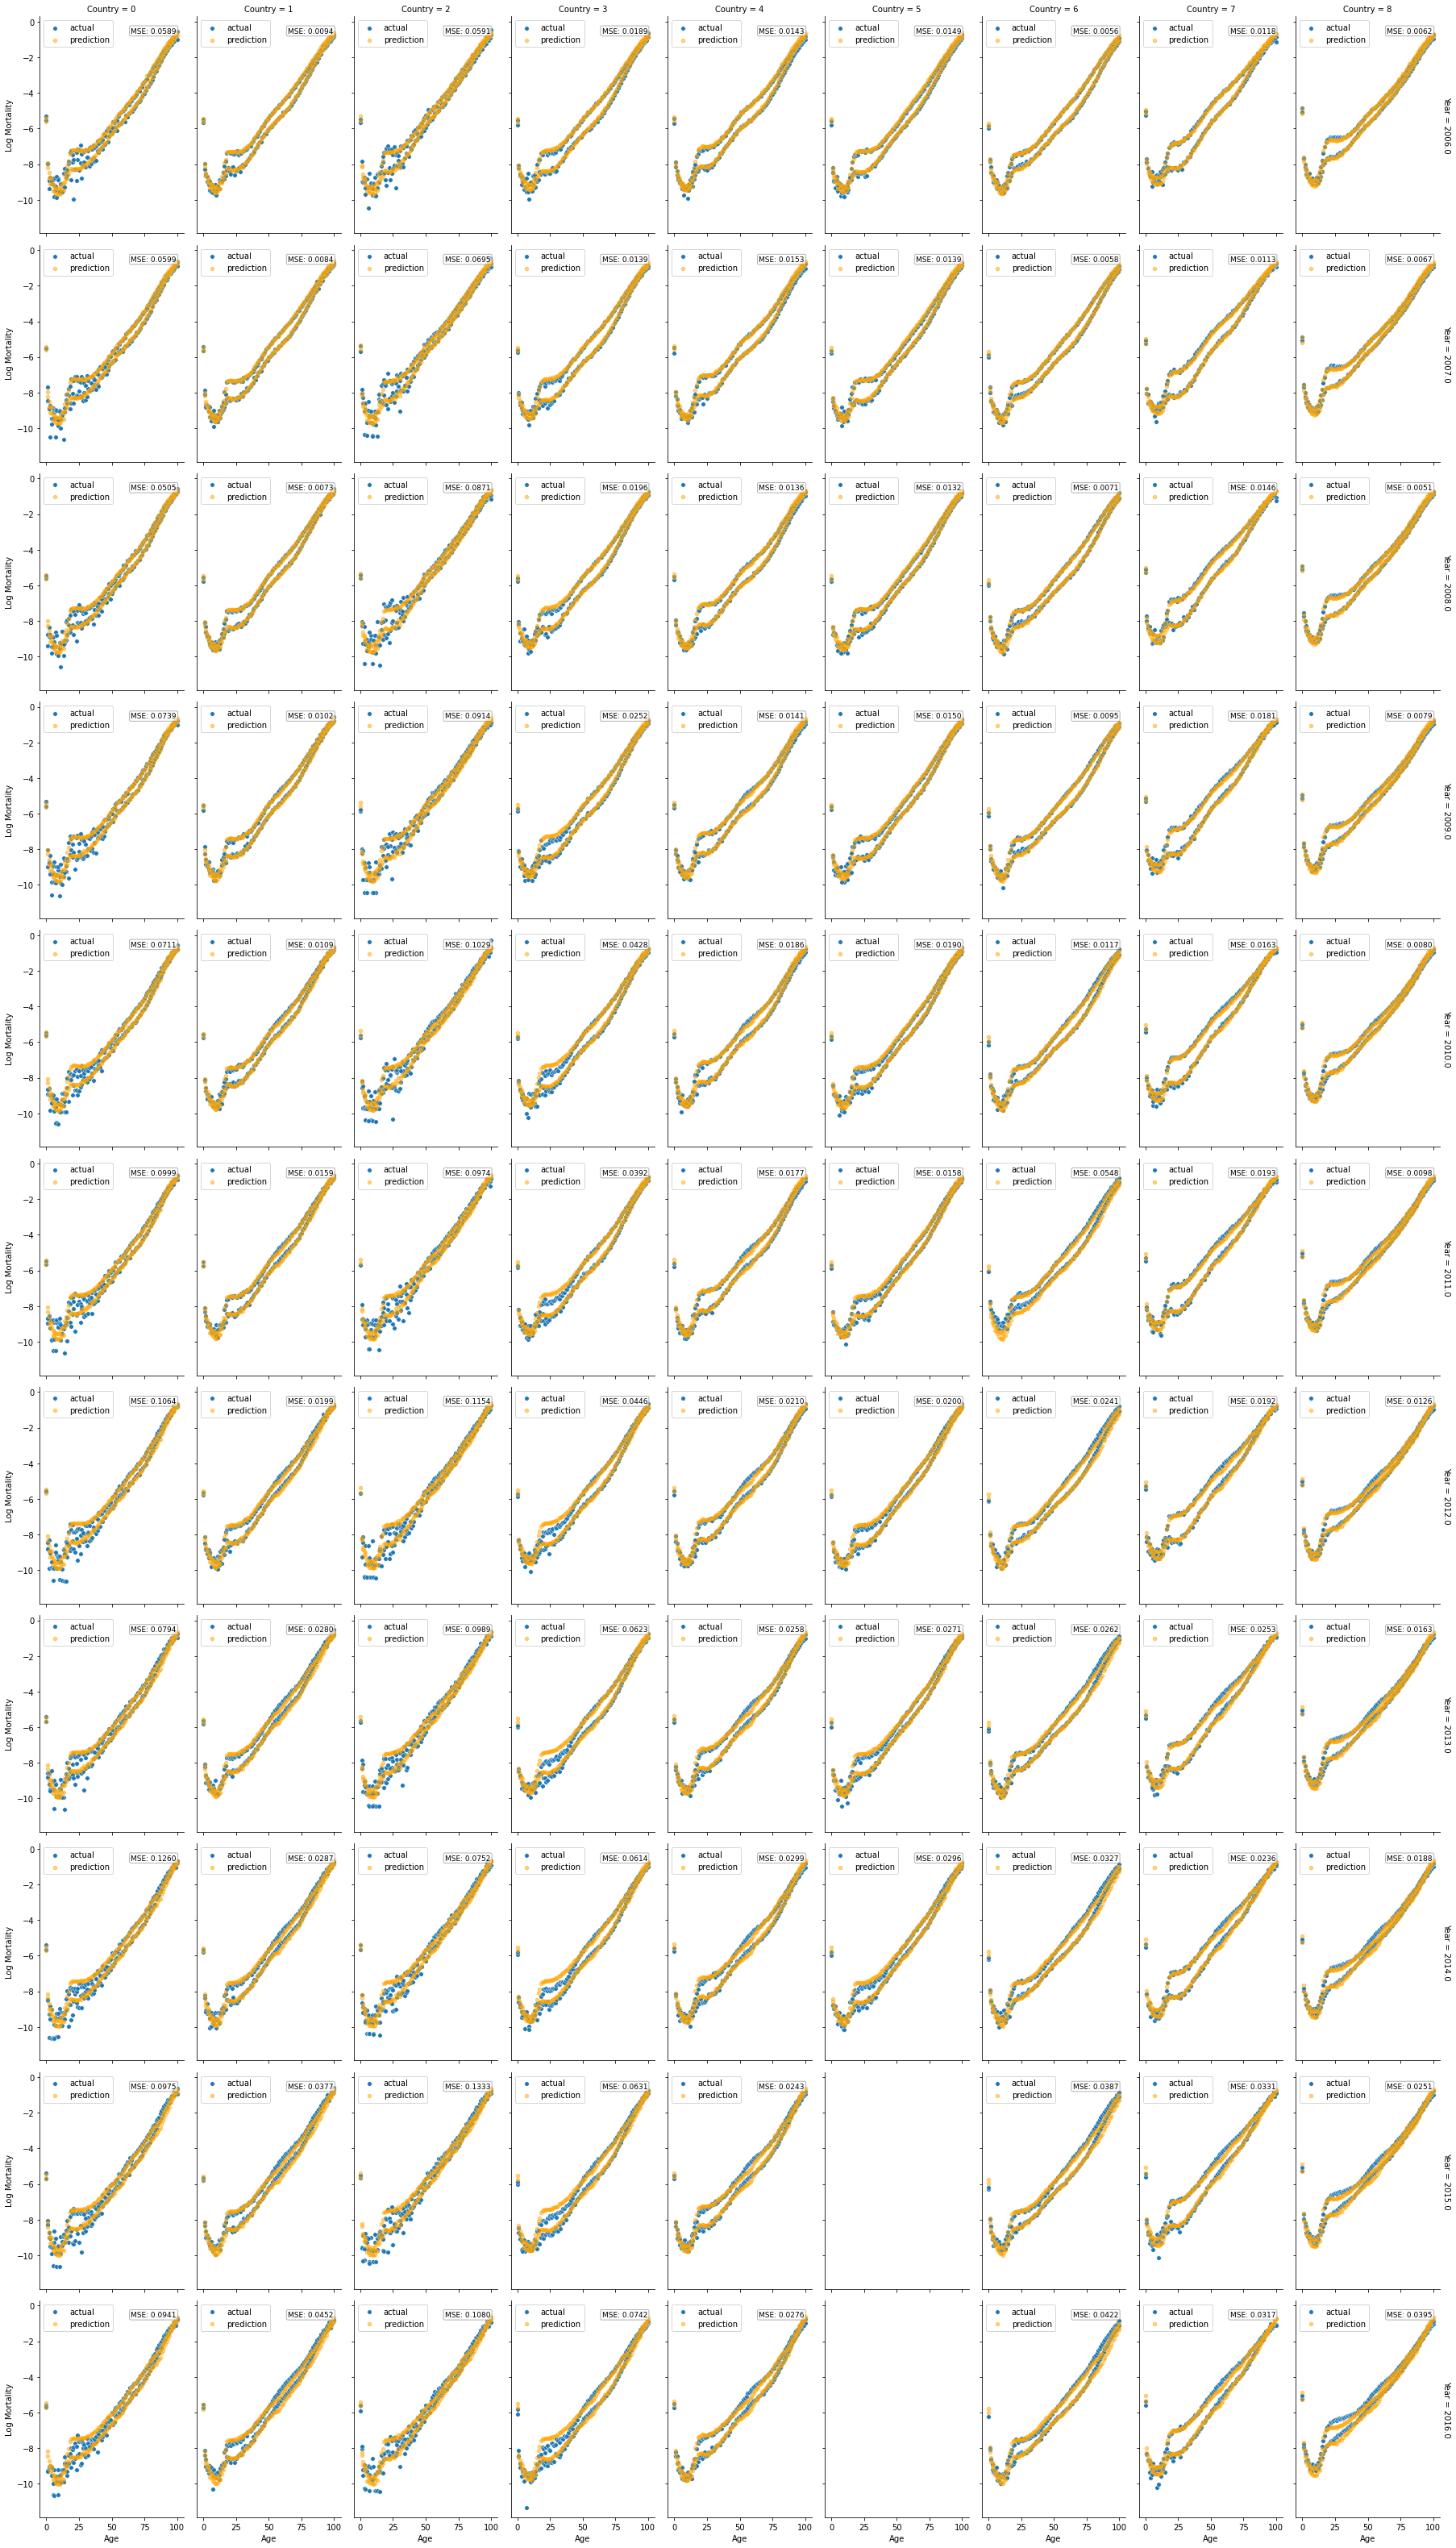

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Compute MSE per (Country, Year)
mse_df = test_set.groupby(['Country', 'Year']).apply(
    lambda group: mean_squared_error(group['log_mortality'], group['prediction'])
).reset_index(name='MSE')

# Step 2: Create the FacetGrid
g = sns.FacetGrid(test_set, col='Country', row='Year', margin_titles=True, height=4, aspect=0.7)

# Step 3: Plot actual values
g.map_dataframe(sns.scatterplot, x='Age', y='log_mortality', s=30, label='actual')

# Step 4: Add predicted values and MSE to each subplot
for (year, country), ax in g.axes_dict.items():
    # Filter data for this subplot
    subset = test_set[(test_set['Country'] == country) & (test_set['Year'] == year)]
    
    # Filter MSE for this subplot
    mse_row = mse_df[(mse_df['Country'] == country) & (mse_df['Year'] == year)]
    
    if not subset.empty:
        # Plot predicted values
        ax.scatter(subset['Age'], subset['prediction'], color='orange', label='prediction', s=20, alpha=0.5)
        ax.legend()

        # Add MSE text annotation in top-right of the subplot
        mse = mse_row['MSE'].values[0]
        ax.text(0.95, 0.95, f"MSE: {mse:.4f}",
                transform=ax.transAxes,
                fontsize=9,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle="round,pad=0.2", edgecolor='gray', facecolor='white', alpha=0.6))

# Step 5: Label axes
g.set_axis_labels("Age", "Log Mortality")

# Step 6: Show the plot
plt.show()


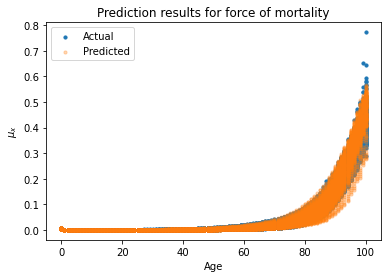

In [28]:
# transfer to force of mortality (instead of log(force of mortality))
test_set['predic_mortality'] = np.exp(test_set['prediction'])
plt.scatter(test_set['Age'], test_set['mortality'], label="Actual", s=10)
plt.scatter(test_set['Age'], test_set['predic_mortality'], label="Predicted", s=10, alpha=0.3)
plt.title('Prediction results for force of mortality')
plt.xlabel('Age')
plt.ylabel('$\mu_x$')
plt.legend()
plt.show()

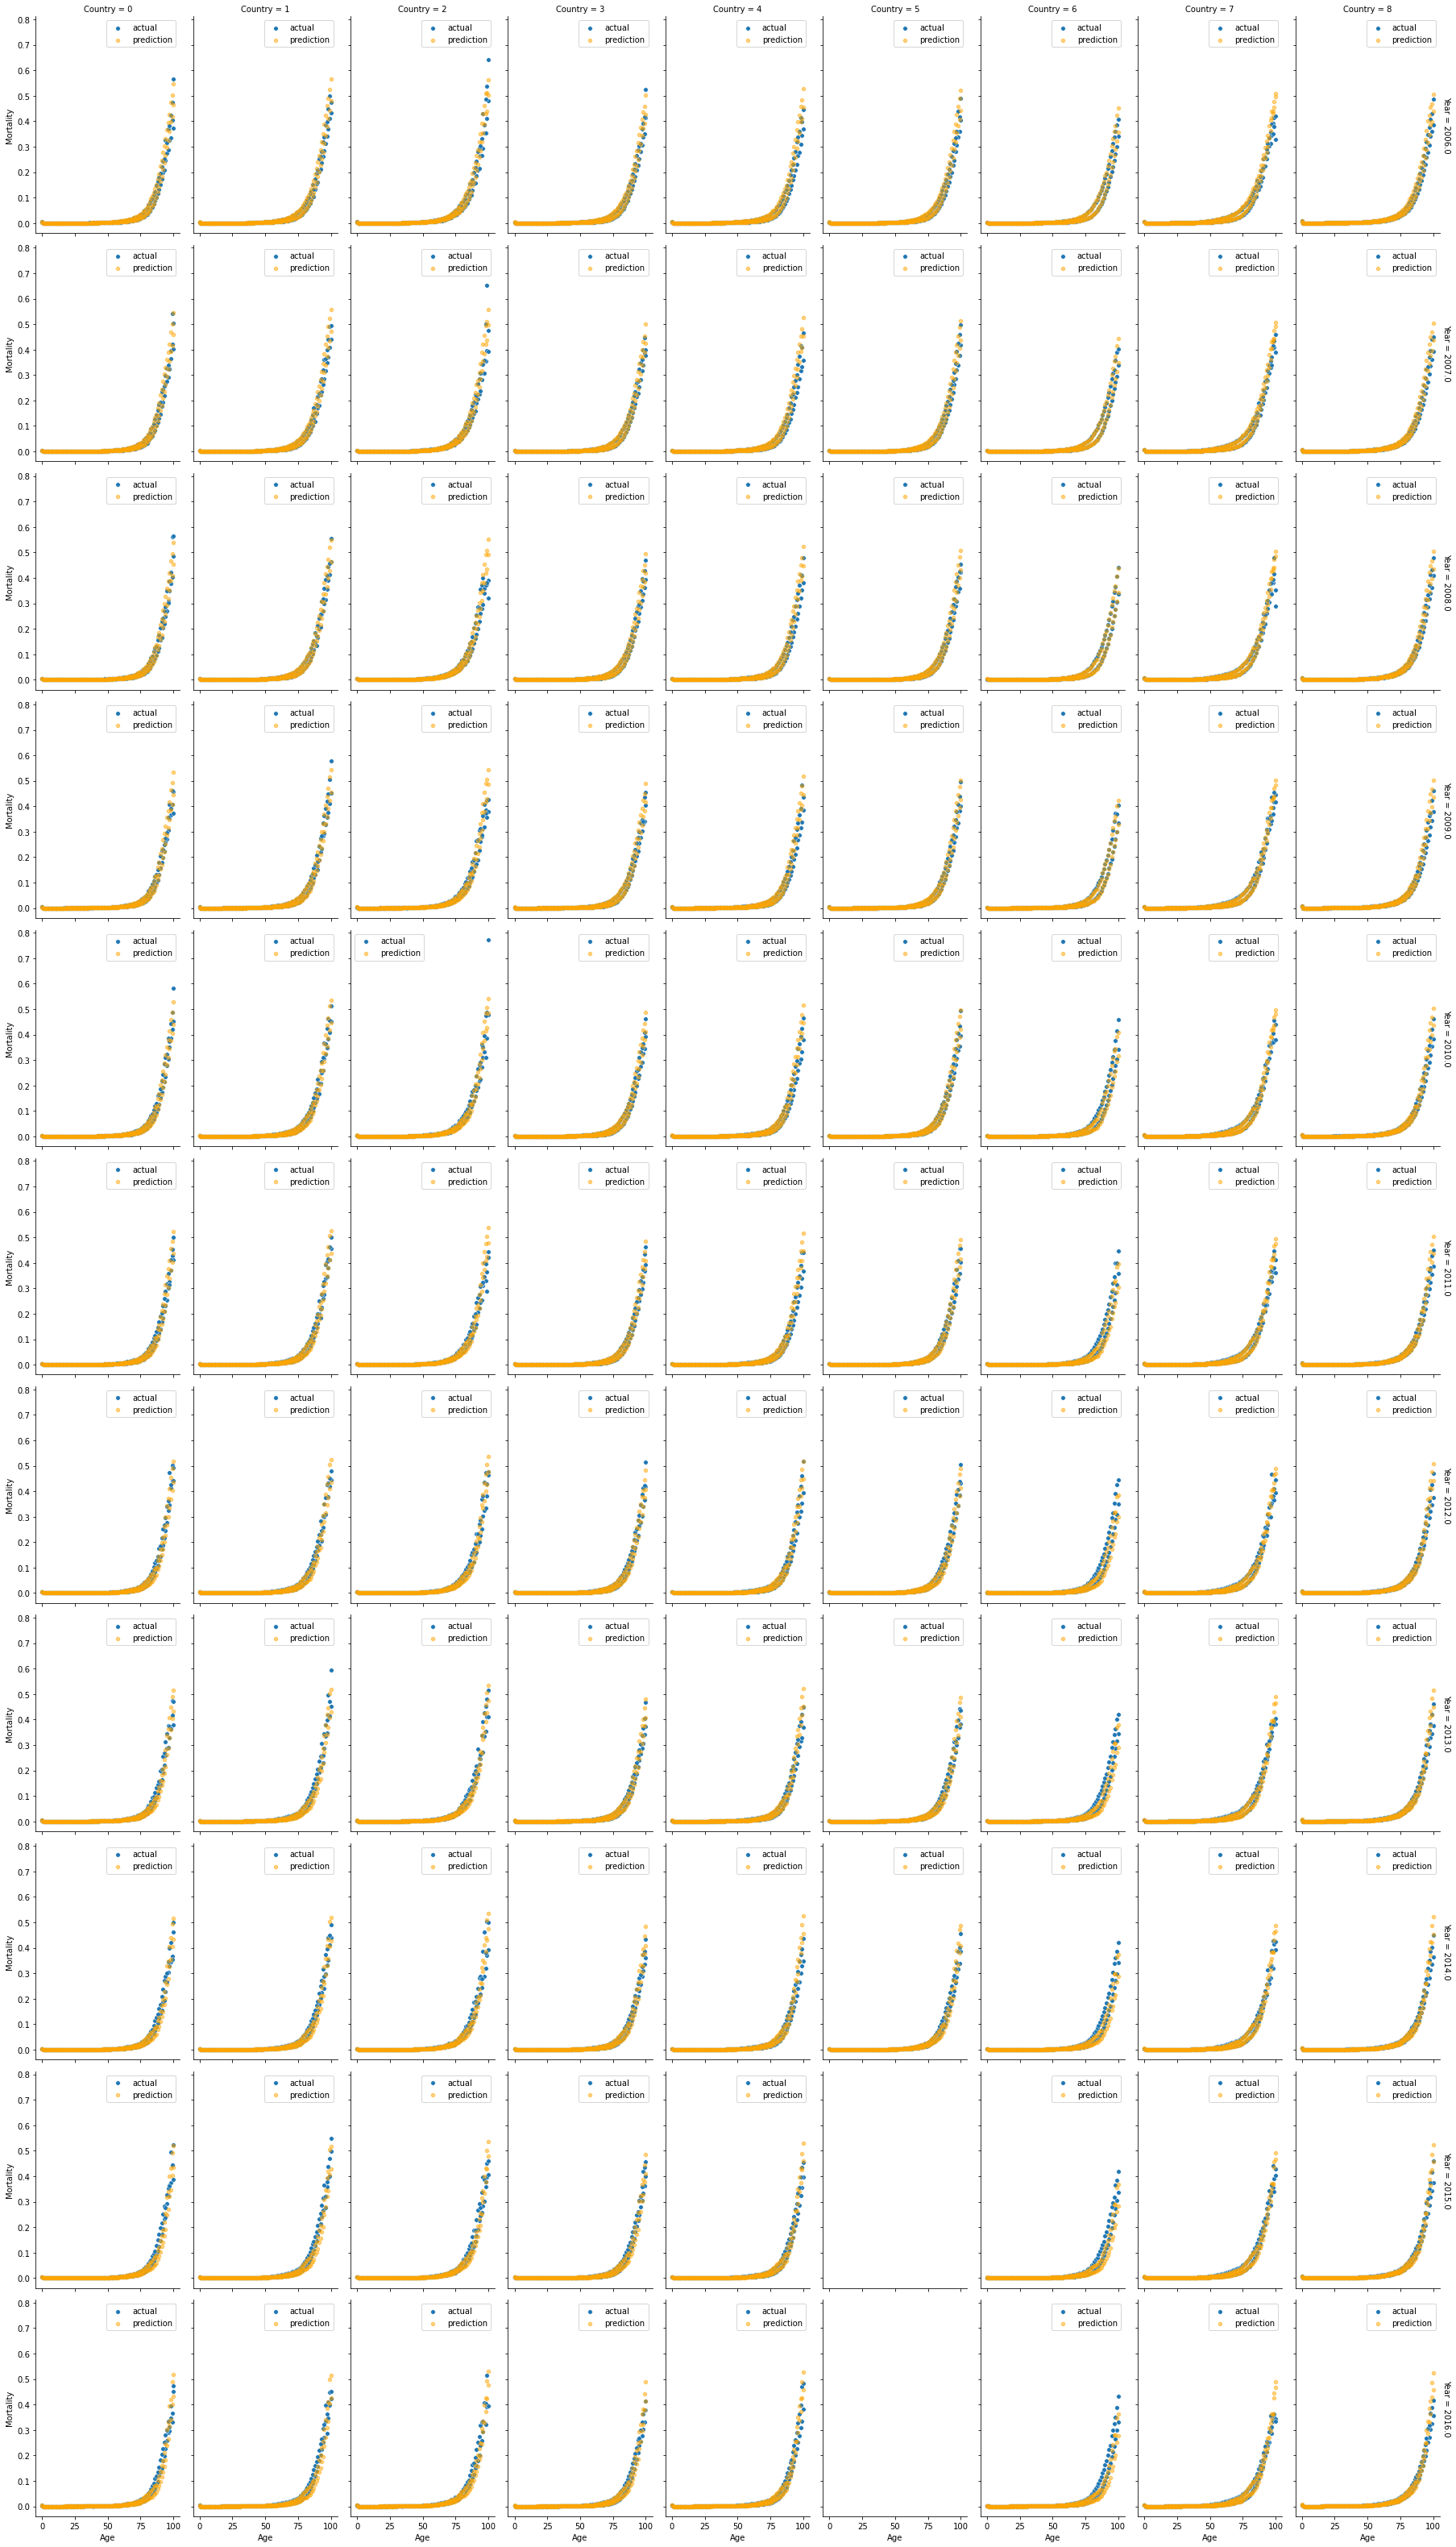

In [26]:
# Create the FacetGrid
g = sns.FacetGrid(test_set, col='Country', row='Year', margin_titles=True, height=4, aspect=0.7)

# Plot actual values
g.map_dataframe(sns.scatterplot, x='Age', y='mortality', s=30, label='actual')

# Loop through axes_dict to ensure correct alignment
for (row_val, col_val), ax in g.axes_dict.items():
    # Filter the subset corresponding to this specific Year and Country
    subset = test_set[(test_set['Year'] == row_val) & (test_set['Country'] == col_val)]
    
    if not subset.empty:
        ax.scatter(subset['Age'], subset['predic_mortality'], color='orange', label='prediction', s=20, alpha=0.5)
        ax.legend()

# Adjust labels
g.set_axis_labels("Age", "Mortality")

# Show plot
plt.show()